# Inference and Validation

In [1]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,))
])

# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/',
                                 download=True,
                                 train=True,
                                 transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=64,
                                          shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/',
                                 download=True,
                                 train=False,
                                 transform=transform)
testloader = torch.utils.data.DataLoader(testset,
                                          batch_size=64,
                                          shuffle=True)

In [2]:
# Create a model
from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

The goal of validation is to measure the model's performance on data that isn't part of the training set. There many options like accuracy, precision an recall, top-5 error rate an so on.

In [3]:
model = Classifier()

images, labels = next(iter(testloader))

# Get the class probabilities
ps = torch.exp(model(images))
# we should get 10 class probabilities for 64 examples
print(ps.shape)

torch.Size([64, 10])


We can get the most likely class using the *ps.topk* method. This returns a tuple of the top-k values and the top-k indices. 

In [4]:
top_p, top_class = ps.topk(1, dim=1)
# look at the most likely classes for the first
# 10 examples
print(top_class[:10,:])

tensor([[0],
        [6],
        [9],
        [9],
        [9],
        [9],
        [6],
        [0],
        [9],
        [6]])


To calculate accuracy, *top_class* and *labels* need to have the same shape.

In [5]:
equals = top_class == labels

In [6]:
# which is wrong!
equals.shape

torch.Size([64, 64])

In [7]:
# instead we should do this
equals = top_class == labels.view(*top_class.shape)

In [8]:
equals.shape

torch.Size([64, 1])

In [9]:
equals

tensor([[False],
        [False],
        [False],
        [False],
        [False],
        [ True],
        [ True],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [ True],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False

Now we need to calculate the percentage of correct predictions.

But first we need to convert them to floats.

In [10]:
accuracy = torch.mean(equals.type(torch.FloatTensor))
print(f'Accuracy: {accuracy.item()*100}%')

Accuracy: 4.6875%


In [11]:
accuracy

tensor(0.0469)

**Exercise**

Implement the validation loop below and print out the total accuracy after the loop.

In [12]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(),
                       lr=0.003)
epochs = 30
steps = 0

train_losses, test_losses = [], []

for epoch in range(epochs):
    running_loss = 0
    
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        val_accuracy = 0
        # Implement the validation pass and
        # print out the validation accuracy
        with torch.no_grad():
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                val_accuracy += torch.mean(equals.type(torch.FloatTensor))
            
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        
        print("Epoch: {}/{}.. ".format(epoch+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(val_accuracy/len(testloader))
             )

Epoch: 1/30..  Training Loss: 0.517..  Test Loss: 0.460..  Test Accuracy: 0.829
Epoch: 2/30..  Training Loss: 0.391..  Test Loss: 0.455..  Test Accuracy: 0.832
Epoch: 3/30..  Training Loss: 0.353..  Test Loss: 0.389..  Test Accuracy: 0.859
Epoch: 4/30..  Training Loss: 0.332..  Test Loss: 0.380..  Test Accuracy: 0.866
Epoch: 5/30..  Training Loss: 0.316..  Test Loss: 0.375..  Test Accuracy: 0.864
Epoch: 6/30..  Training Loss: 0.304..  Test Loss: 0.389..  Test Accuracy: 0.869
Epoch: 7/30..  Training Loss: 0.291..  Test Loss: 0.362..  Test Accuracy: 0.874
Epoch: 8/30..  Training Loss: 0.279..  Test Loss: 0.348..  Test Accuracy: 0.876
Epoch: 9/30..  Training Loss: 0.272..  Test Loss: 0.356..  Test Accuracy: 0.880
Epoch: 10/30..  Training Loss: 0.266..  Test Loss: 0.397..  Test Accuracy: 0.867
Epoch: 11/30..  Training Loss: 0.259..  Test Loss: 0.356..  Test Accuracy: 0.883
Epoch: 12/30..  Training Loss: 0.255..  Test Loss: 0.394..  Test Accuracy: 0.872
Epoch: 13/30..  Training Loss: 0.247.

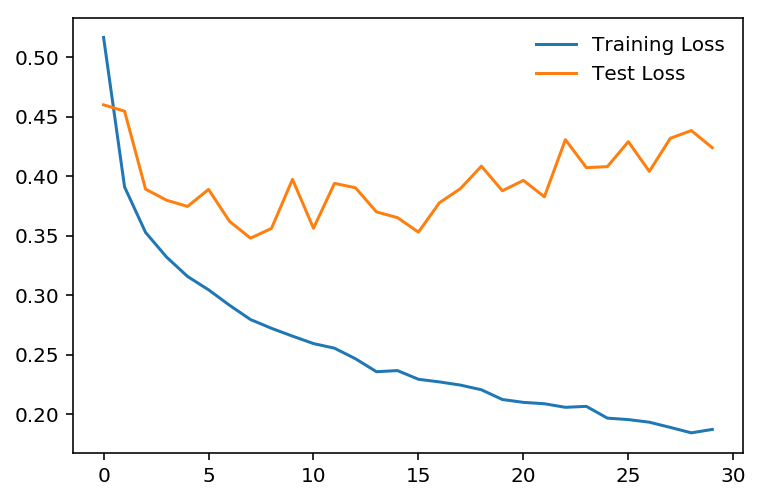

In [13]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend(frameon=False)

# Overfitting

The most common method to reduce overfittin is dropot, where we randomly drop input units. This forces the network to share information between weights, increasing it's ability to generalize to new data.

We need to turn off dropout during validation, testing and whenever we're using the network to make predictions.

**Exercise**

Add dropout to your model and train it on Fasion-MNIST again. Try to get a lower validation loss or higher accuracy.

In [23]:
import torch.nn.functional as F
from torch import nn, optim
# Define the model with dropout

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        # with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        
        # output, so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

In [26]:
# Train the model with dropout, and monitor
# the training process with the validation loss
# and accuracy
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 3
steps = 0

train_losses, test_losses = [], []

for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        logps = model(images)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    else:
        val_accuracy = 0
        test_loss = 0
        
        with torch.no_grad():
            model.eval()
            for images, labels in testloader:
                logps = model(images)
                loss = criterion(logps, labels)
                test_loss += loss
                
                ps = torch.exp(logps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                val_accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        model.train()
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        
        print("Epoch {}/{}".format(epoch+1, epochs),
              "Training Loss.. {}".format(running_loss/len(trainloader)),
              "Testing Loss.. {}".format(test_loss/len(testloader)),
              "Validation Accuracy.. {}".format(val_accuracy/len(testloader)))

Epoch 1/3 Training Loss.. 0.6024023583417 Testing Loss.. 0.5125457644462585 Validation Accuracy.. 0.8179737329483032
Epoch 2/3 Training Loss.. 0.4350975245110262 Testing Loss.. 0.4442942440509796 Validation Accuracy.. 0.8428543210029602
Epoch 3/3 Training Loss.. 0.397043892982672 Testing Loss.. 0.44196659326553345 Validation Accuracy.. 0.8456408977508545


In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

# Inference

We need to set the model in inference mode with *model.eval()*.

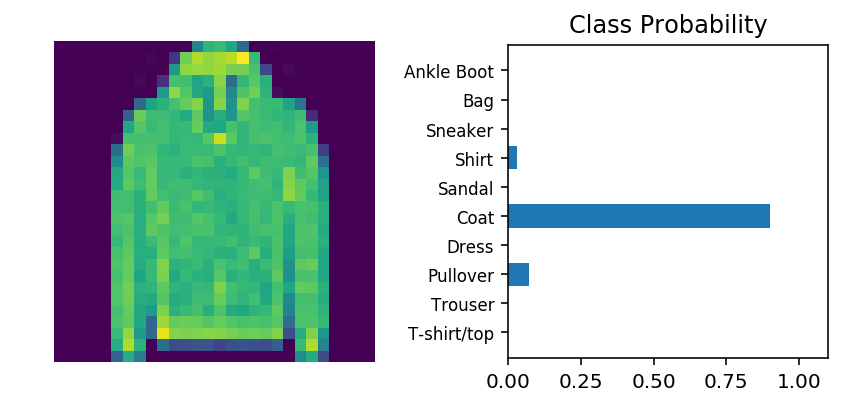

In [29]:
import helper

model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]

# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities 
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)

# Plot the image and probabilities
helper.view_classify(img.view(1, 28, 28), 
                     ps, 
                     version='Fashion')